array([[<AxesSubplot: title={'center': 'age'}>,
        <AxesSubplot: title={'center': 'sex'}>,
        <AxesSubplot: title={'center': 'cp'}>,
        <AxesSubplot: title={'center': 'trestbps'}>],
       [<AxesSubplot: title={'center': 'chol'}>,
        <AxesSubplot: title={'center': 'fbs'}>,
        <AxesSubplot: title={'center': 'restecg'}>,
        <AxesSubplot: title={'center': 'thalach'}>],
       [<AxesSubplot: title={'center': 'exang'}>,
        <AxesSubplot: title={'center': 'oldpeak'}>,
        <AxesSubplot: title={'center': 'slope'}>,
        <AxesSubplot: title={'center': 'ca'}>],
       [<AxesSubplot: title={'center': 'thal'}>,
        <AxesSubplot: title={'center': 'target'}>, <AxesSubplot: >,
        <AxesSubplot: >]], dtype=object)

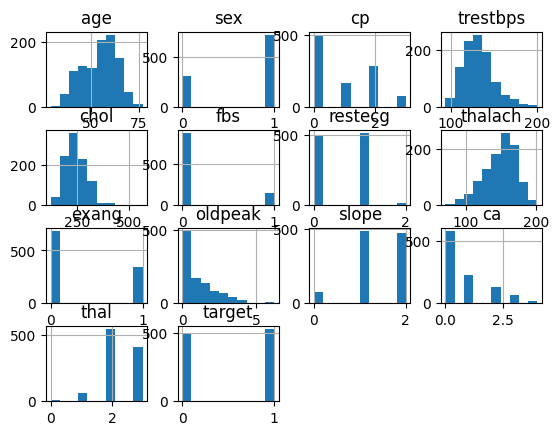

In [5]:
import pandas as pd
import seaborn as sns

data = pd.read_csv("./heart.csv", sep=",")
istogramma = data[["age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang","oldpeak","slope","ca","thal","target"]]
data.hist()

In [6]:
import pandas as pd
import matplotlib as plb
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import imblearn
from collections import Counter

def pre(data): 
    to_drop_columns = [ 'exang', 'ca', 'cp', 'slope', 'oldpeak', 'restecg']
    data.drop(to_drop_columns, axis=1, inplace=True)
    colonne_tenute = ["age","sex","trestbps","chol","fbs","thalach","thal", "target"]
    
    scaler = preprocessing.MinMaxScaler((0, 1))
    data = scaler.fit_transform(data)
    data = pd.DataFrame(data=data, columns=colonne_tenute)

    oversample = imblearn.over_sampling.SMOTE() #usa k-nearest-neighbours
    x_data, y_data = oversample.fit_resample(data.iloc[: , : -1], data["target"])


    return x_data, y_data
        

In [7]:
def pre_Kfold(data):
    colonne_tenute = ["age","sex","trestbps","chol","fbs","thalach","thal", "target"]
    scaler = preprocessing.MinMaxScaler((0, 1))
    data = scaler.fit_transform(data)
    data = pd.DataFrame(data=data, columns=colonne_tenute)

    oversample = imblearn.over_sampling.SMOTE() #usa k-nearest-neighbours
    x_data, y_data = oversample.fit_resample(data.iloc[: , : -1], data["target"])


    return x_data, y_data

In [8]:
from sklearn import naive_bayes
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import absolute

x_train, y_train = pre(data)
flag = 0

for i in range (0, 50):
    pre_Kfold(data)
    cv = KFold(n_splits=10)
    model = RandomForestClassifier(criterion='entropy', max_depth=12, min_samples_split=5, min_samples_leaf=1, max_features=6)
    score = cross_val_score(model, x_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1) #errore assoluto per 10 split
    flag = flag + mean(absolute(score))
print(flag/50)
#fa 10 volte il training e stampa la media dell'errore assoluto di ogni validazione

0.006413656783468103


/var/folders/fx/zsdh_8412glbjpkff1h6xdlh0000gn/T/ipykernel_2470/3058096324.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
/var/folders/fx/zsdh_8412glbjpkff1h6xdlh0000gn/T/ipykernel_2470/3058096324.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


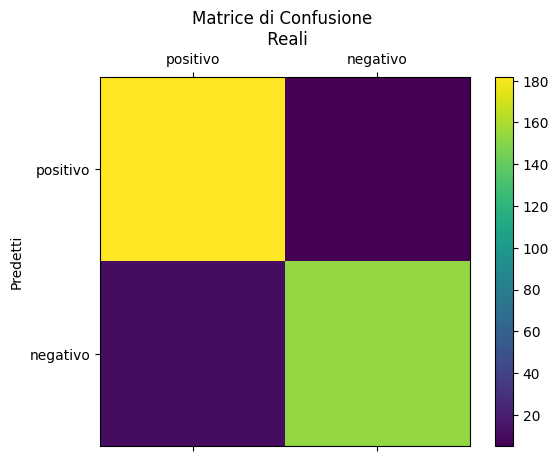

recall =  0.9329268292682927
precision =  0.9683544303797469
accuracy =  0.9544159544159544
f1 =  0.9503105590062113


In [9]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

model = RandomForestClassifier(criterion='entropy', max_depth=12, min_samples_split=5, min_samples_leaf=1, max_features=6)
model.fit(x_train[:700], y_train[:700])
prediction = model.predict(x_train[701:])

labels = ['positivo', 'negativo']
matrice = confusion_matrix(y_train[701:], prediction)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(matrice)
plt.title('Matrice di Confusione \n Reali')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.ylabel('Predetti')
#plt.xlabel('Reali')
plt.show()

recall_value = recall_score(y_train[701:], prediction)
print("recall = ", recall_value)

precision_value = precision_score(y_train[701:], prediction)
print("precision = ", precision_value)

accuracy_value = accuracy_score(y_train[701:], prediction)
print("accuracy = ", accuracy_value)

fmeasure_value = f1_score(y_train[701:], prediction)
print("f1 = ", fmeasure_value)

In [10]:
import flask
from flask import request, jsonify
from flask import Response
import numpy as np
import pandas as pd

app = flask.Flask(__name__)

@app.route('/', methods=['POST'])
def predici():
    query_parameters = request.get_json()
    x_data = pd.DataFrame(query_parameters, index=[0])
    
    age = query_parameters["age"]
    sex = query_parameters["sex"]
    trestbps = query_parameters["trestbps"]
    chol = query_parameters["chol"]
    fbs = query_parameters["fbs"]
    thalach = query_parameters["thalach"]
    thal = query_parameters["thal"]

    v = np.array(x_data)
    print(v)

    scaler = preprocessing.MinMaxScaler((0, 1))
    x_data = scaler.fit_transform(v.reshape(7,1))


    colonne_tenute = ["age","sex","trestbps","chol","fbs","thalach","thal"]
    x_data = pd.DataFrame(data=x_data.reshape(1, 7), columns=colonne_tenute)

    print("dopo scaling \n", x_data)

  
    
    #chiama il modello
    result = model.predict(x_data)
    
    print(result)

    return str(result)

if __name__ == "__main__":
    app.run(port=8083)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:8083
Press CTRL+C to quit
127.0.0.1 - - [15/Feb/2023 12:52:49] "POST / HTTP/1.1" 200 -


[[ 40   1 100 150   0  85   0]]
dopo scaling 
         age       sex  trestbps  chol  fbs   thalach  thal
0  0.266667  0.006667  0.666667   1.0  0.0  0.566667   0.0
[0.]
